In [1]:
import requests
import io
import zipfile

import numpy as np
import pandas as pd
import pydotplus

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  

import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart
from IPython.display import Image  

# Na początku robimy to samo co w pracy domowej 1

tylko tym razem w Pythonie...

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as tmp_zip:
    for zip_file in tmp_zip.infolist():
        with tmp_zip.open(zip_file, 'r') as f:
            stata_file = io.BytesIO(f.read())

In [3]:
stata_file.seek(0)
data = pd.read_stata(stata_file)

# Obrabiamy dane jak poprzednio


In [4]:
data = data[['S1', 'Q9', 'Q19', 'Q26', 'ppage']]

In [5]:
for column in data.columns:
    data = data[data[column] != 'Refused']
    data[column].cat.remove_unused_categories()
data = data.dropna()
data[['Q9', 'ppage']] = data[['Q9', 'ppage']].apply(pd.to_numeric, axis=1)

In [6]:
data.sample(5)

,S1,Q9,Q19,Q26,ppage
681,"Yes, I am Married",51.0,Yes,Did not attend same college or university,56.0
2983,"Yes, I am Married",62.0,Yes,Did not attend same college or university,68.0
2933,"Yes, I am Married",41.0,Yes,Did not attend same college or university,45.0
247,"Yes, I am Married",27.0,Yes,Did not attend same college or university,28.0
1412,"Yes, I am Married",70.0,Yes,Attended same college or university,68.0


In [7]:
y = data['S1']
x = data.drop('S1', axis=1)

# Robimy model

In [8]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

le_q19 = LabelEncoder()
x['Q19'] = le_q19.fit_transform(x['Q19'])

le_q26 = LabelEncoder()
x['Q26'] = le_q26.fit_transform(x['Q26'])

In [9]:
ohe = OneHotEncoder(categorical_features=[1, 2], 
                    dtype=np.int64,
                    sparse=False)
x = pd.DataFrame(ohe.fit_transform(x.values))
x.columns = ['Q19_0', 'Q19_1', 'Q26_0', 'Q26_1', 'Q9', 'ppage']

In [10]:
x.drop(['Q19_0', 'Q26_0'], axis=1, inplace=True)
x.head()

,Q19_1,Q26_1,Q9,ppage
0,1.0,1.0,52.0,55.0
1,1.0,1.0,45.0,47.0
2,1.0,1.0,59.0,59.0
3,1.0,1.0,65.0,65.0
4,1.0,1.0,43.0,33.0


In [11]:
rfc = RandomForestClassifier(max_depth=4,
                             n_estimators=30,
                             max_features=None)
rfc.fit(x, y)

y_pred = rfc.predict(x)
accuracy_score(y, y_pred)

0.8761844598862919

# Wyjaśniamy model przez variable attribution

In [12]:
class MeanPredictionChangePlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_mean_prediction_change_plot(self, observation, *args):
        # compute prediction means and differences between them
        tmp = self.x.copy()
        means = []
        names = []
        names.append('sample_mean')
        mean = self.clf.predict_proba(tmp)[:, 1]\
                       .mean()
        means.append(mean)
        
        for arg in args:
            tmp[arg] = observation[arg].values[0]
            mean = self.clf.predict_proba(tmp)[:, 1]\
                           .mean()
            means.append(mean)
            names.append(arg)
            
        means = np.concatenate((np.array([means[0]]), np.diff(np.array(means))))
        
        # draw the plot
        waterfall_chart.plot(names, 
                             means,
                             formatting='{:,.3f}',
                             rotation_value=90)
        
        return


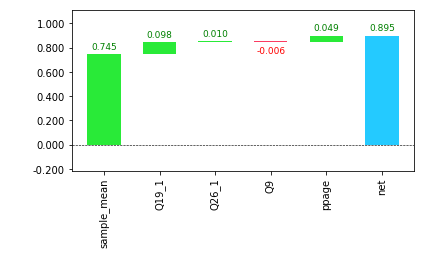

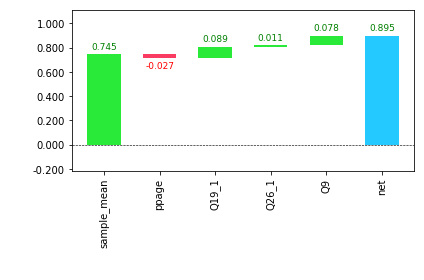

In [13]:
joe = pd.DataFrame({'Q19_1': [1], 'Q26_1': [0], 'Q9': [40], 'ppage': [41]},
                   columns=x.columns)

mpcp = MeanPredictionChangePlotter(rfc, x)
mpcp.draw_mean_prediction_change_plot(joe, 'Q19_1', 'Q26_1', 'Q9', 'ppage')
mpcp.draw_mean_prediction_change_plot(joe,  'ppage', 'Q19_1', 'Q26_1', 'Q9')

Rozważono dwie kolejności zmiennych:

* Najpierw zmienne jakościowe, następnie ciągłe
* Najpierw jedna zmienna ciągła, następnie jakościowe i pozostałe ciągłe

Ciekawą obserwacją są kierunki zmian średnich predykcji przy ustalaniu zmiennych ciągłych. Przy ustaleniu zmiennej ppage na samym końcu mamy dość silną dodatnią zmianę. Natomiast przy zamrożeniu zmiennej 'ppage' na samym początku otrzymujemy efekt w kierunku ujemnym! Również druga ze zmiennych zmienia znak w obydwu przypadkach. Może to mieć związek z wysokim skorelowaniem wieku partnerów.



# Wyjaśniamy model przez LIME

In [14]:
class LimePlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
    
    def draw_lime_model_approximation(self, 
                                      observation, 
                                      sample_num, 
                                      categorical_columns,
                                      numerical_columns,
                                      epsilon):
        # sample around observation
        similar_observations = pd.DataFrame(columns=categorical_columns + numerical_columns)
        
        for _ in range(sample_num):
            similar_observation_cat = dict(((cc, 0 + np.random.randint(0, 2)) 
                                            for cc in categorical_columns))
            similar_observation_num = dict(((nc, observation[nc] + np.random.randint(-epsilon, epsilon)) 
                                            for nc in numerical_columns))
            similar_observation = {**similar_observation_cat, **similar_observation_num}
            similar_observation_df = pd.DataFrame(similar_observation,
                                                  columns=categorical_columns + numerical_columns,
                                                  index=(0,))
            similar_observations = similar_observations.append(similar_observation_df, 
                                                               ignore_index=True)
        
        # calculate distances from sample to observation
        similar_observations_dist = similar_observations.apply(lambda x: np.sum(np.absolute(x.values - observation.values)) + 1,
                                                               axis=1)
        
        # predict on sample
        y_sample_pred = self.clf.predict(similar_observations)
        
        # fit simple classifier
        dt = DecisionTreeClassifier(max_depth=2)
        dt.fit(similar_observations, 
                y_sample_pred, 
                sample_weight=(1 / similar_observations_dist.values))
        
        # draw the model
        dot_data = StringIO()
        export_graphviz(dt, 
                        out_file=dot_data,
                        feature_names = similar_observations.columns,
                        filled=True, 
                        rounded=True,
                        special_characters=True)

        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        return graph

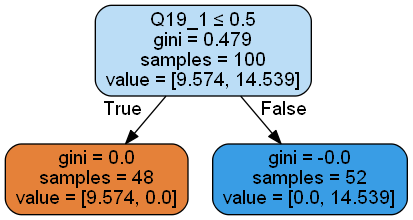

In [15]:
lp = LimePlotter(rfc, x)
graph = lp.draw_lime_model_approximation(joe, 100, ('Q19_1', 'Q26_1'), ('Q9', 'ppage'), 3)
Image(graph.create_png())

W pobliżu naszej obserwacji tj. respondenta Joe, 41-latka, który mieszka ze swoją 40-letnią partnerką partnerką, której nie poznał na studiach, najważniejszym predyktorem jest zmienna odpowiadająca na pytanie, czy partnerzy obecnie ze sobą mieszkają. Odpowiedź pozytywna implikuje, że respondent jest w związku małżeńskim, natomiast negatywna, że nie jest. 

Wynik ten jest zgodny z poprzednią pracą domową i rzuca nowe światło na model: przynajmniej w otoczeniu naszej obserwacji głównym predyktorem decydującym o wyniku jest zmienna Q19_1. Zmienna ta posiada również najwyższy wynik dodatni w breakdown plotach.